# Transfer Learning 
We use networks pre-trained on a large data set to identify features in a smaller but similar dataset. We then build only the additional layers required for classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf
np.random.seed(42)
tf.set_random_seed(42)

import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2, ResNet50, InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

## Build a model
We use MobileNet, a residual network designed for mobile applications, then attach a new classifier to it.

In [3]:
base_model=MobileNetV2(weights='imagenet', #model MobileNetV2 has been trained on imagenet dataset
                       include_top=False, # drop the classifier
                       pooling='avg') # global average pooling applied to last block, output is 2D
x=base_model.output
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W1008 17:33:54.229360 139728331085568 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 17:33:54.230326 139728331085568 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 17:33:54.236427 139728331085568 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend

In [4]:
# Instantiate the model and specify input and output layers
model=Model(inputs=base_model.input,outputs=preds)

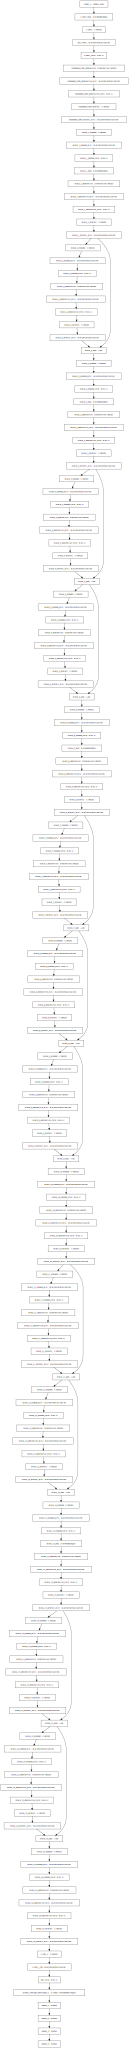

In [5]:
# Plot model graph
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
# lock the pre-trained layers
for layer in model.layers[:-4]:
    layer.trainable=False
for layer in model.layers[-4:]:
    layer.trainable=True

## Use an image generator
The image generator will build out a dataset for processing from a directory structure where the directory names are classes for the picture files within

In [7]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./train/', # path to the training dataset
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='categorical',
                                                 shuffle=True)
test_generator=test_datagen.flow_from_directory('./test/', # path to the validation dataset
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 182 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


## Build the computation graph
Keras is a static framework. The graph is compiled before computation. We specify:
- Optimizer
- Loss function
- Metrics to track

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Categorical cross entropy loss
# Accuracy metric

W1008 17:34:16.870789 139728331085568 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Train the model
We require:
- training data, from the training generator
- validation data, from the test generator
- number of epochs (i.e. iterations through all dataset)
- steps per epoch, typically the number of samples / batch size
- validation steps per epoch

In [9]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=test_generator.n//test_generator.batch_size
print (step_size_train, step_size_val)

22 1


In [10]:
history=model.fit_generator(generator=train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=step_size_train,
                            validation_steps=step_size_val,
                            epochs=5)

W1008 17:34:21.401073 139728331085568 deprecation.py:323] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
22/22 [==============================] - 13s 574ms/step - loss: 0.7356 - acc: 0.7500 - val_loss: 0.2706 - val_acc: 0.8750
Epoch 2/5
22/22 [==============================] - 6s 257ms/step - loss: 0.2608 - acc: 0.8941 - val_loss: 0.0626 - val_acc: 1.0000
Epoch 3/5
22/22 [==============================] - 7s 305ms/step - loss: 0.2947 - acc: 0.8959 - val_loss: 0.2233 - val_acc: 0.8750
Epoch 4/5
22/22 [==============================] - 6s 266ms/step - loss: 0.2866 - acc: 0.9261 - val_loss: 0.0184 - val_acc: 1.0000
Epoch 5/5
22/22 [==============================] - 7s 303ms/step - loss: 0.2983 - acc: 0.8959 - val_loss: 0.1029 - val_acc: 1.0000


## Plot accuracy and loss
Note that the last loss or accuracy value is not always the best one.
Keras offers checkpointing - more on that later.

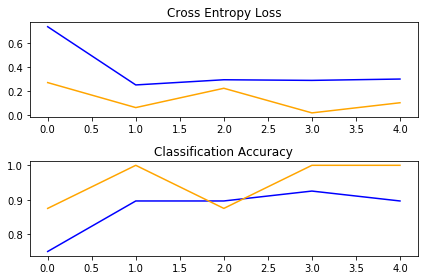

In [11]:
# plot loss
plt.subplot(2,1,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.title('Cross Entropy Loss')
# plot accuracy
plt.subplot(2,1,2)
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
plt.title('Classification Accuracy')
# save plot to file
filename = 'mobilenet'
plt.savefig(filename + '_plot.png')
plt.tight_layout()
plt.show()
plt.close()



In [12]:
# now try with Inception network

In [13]:
base_model=InceptionV3(weights='imagenet',
                       pooling='avg',
                       include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
for layer in base_model.layers:
            layer.trainable = False
x=base_model.output
x=Dense(128,activation='relu')(x) #dense layer 1
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

W1008 17:38:05.724215 139728331085568 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1008 17:38:06.382761 139728331085568 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



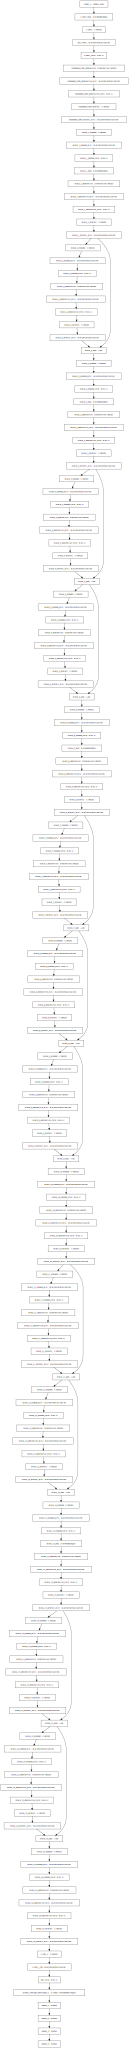

In [14]:
# Plot model graph
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Categorical cross entropy loss
# Accuracy metric

In [16]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=test_generator.n//test_generator.batch_size
print (step_size_train, step_size_val)

history=model.fit_generator(generator=train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=step_size_train,
                            validation_steps=step_size_val,
                            epochs=5)

22 1
Epoch 1/5
22/22 [==============================] - 9s 422ms/step - loss: 0.6572 - acc: 0.8181 - val_loss: 0.2457 - val_acc: 0.8750
Epoch 2/5
22/22 [==============================] - 5s 231ms/step - loss: 0.2190 - acc: 0.9147 - val_loss: 0.1800 - val_acc: 1.0000
Epoch 3/5
22/22 [==============================] - 6s 267ms/step - loss: 0.1156 - acc: 0.9602 - val_loss: 0.0216 - val_acc: 1.0000
Epoch 4/5
22/22 [==============================] - 6s 284ms/step - loss: 0.0761 - acc: 0.9811 - val_loss: 0.0228 - val_acc: 1.0000
Epoch 5/5
22/22 [==============================] - 6s 286ms/step - loss: 0.1877 - acc: 0.9318 - val_loss: 6.9392e-04 - val_acc: 1.0000


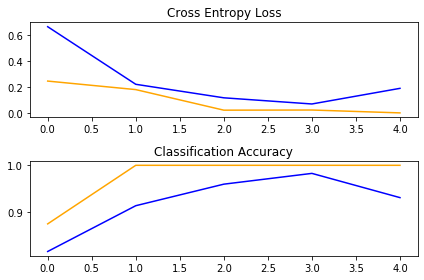

In [17]:
# plot loss
plt.subplot(2,1,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.title('Cross Entropy Loss')
# plot accuracy
plt.subplot(2,1,2)
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
plt.title('Classification Accuracy')
# save plot to file
filename = 'inceptionv3'
plt.savefig(filename + '_plot.png')
plt.tight_layout()
plt.show()
plt.close()